In [39]:
import sys 
sys.path.append("/home/eddie_akers_anchorlabs_com/anchorage/source/python/trading/agency_desk")
from lib import talos_utils

sys.path.append("/home/eddie_akers_anchorlabs_com/anchorage/source/python/quant_lib/anchoragequantlib")
import google_sheet_utility as aql_google_sheet_utility
import utils as aql_utils
import json
import pandas as pd

<font face = "Times New Roman">

### ***Import library and add block pricer folder path*** 
In this section, you will need to add the block pricer folder path into this cell.

* for first time running, you might install all required packages in your environment, two ways to do this: 

    * In terminal: run "pip install numpy ccxt pandas matplotlib "

    * There is a txt file called requirements.txt in Block Pricer folder,  run "pip install -r requirements.txt"


 
</font>

In [40]:

import os 
#lib_path = os.path.expanduser("~") + "/trading/python/block_pricer" 
#sys.path.append(lib_path) 
import fair_price as fp
import volatility_model as vol
import constants 

<font face = "Times New Roman">

### ***Initializing All Avaliable Exchanges***
This section is default setting for now, no need make any change.Fees data is from Talos API  

<font>

In [41]:
full_exchanges = fp.get_exchanges(constants.full_exchange_list, constants.exchange_credentials)
fx_exchanges = fp.get_exchanges(constants.fx_exchange_list, constants.exchange_credentials)

[2024-07-16T14:05:50.866+0000] {fair_price.py:272} INFO - Loading exchange coinbaseexchange
[2024-07-16T14:05:51.351+0000] {fair_price.py:272} INFO - Loading exchange okx
[2024-07-16T14:05:52.928+0000] {fair_price.py:272} INFO - Loading exchange kraken
[2024-07-16T14:05:54.055+0000] {fair_price.py:272} INFO - Loading exchange okx_perp
[2024-07-16T14:05:55.530+0000] {fair_price.py:272} INFO - Loading exchange binance
[2024-07-16T14:05:55.576+0000] {fair_price.py:283} WARNING - Exchange binance not found
[2024-07-16T14:05:55.578+0000] {fair_price.py:272} INFO - Loading exchange bybit
[2024-07-16T14:05:55.636+0000] {fair_price.py:283} WARNING - Exchange bybit not found
[2024-07-16T14:05:55.637+0000] {fair_price.py:272} INFO - Loading exchange kraken
[2024-07-16T14:05:56.762+0000] {fair_price.py:272} INFO - Loading exchange coinbaseexchange
[2024-07-16T14:05:56.948+0000] {fair_price.py:272} INFO - Loading exchange okx


In [38]:
full_exchanges

{'coinbaseexchange': ccxt.coinbaseexchange(),
 'okx': ccxt.okx(),
 'kraken': ccxt.kraken(),
 'okx_perp': ccxt.okx(),
 'binance': None,
 'bybit': None}

<font face = "Times New Roman">

### ***Config section*** 
In this section, you will need to input the exchange you want to choose, base_ccy and quote_ccy, side, quantity, is_quantity, estimated_delivery_time, participating_rate

* ***exchange_list***: choose the exchange has access or inventory to calculate the price. Currently support 'okx','okx_perp','kraken','coinbaseexchange',
* ***base_ccy***:  base currency in a string format, need to be capitalized
* ***quote_ccy***:  can be 'USD' 'USDC' or 'USDT'
* ***quantity***: set the client quantity amount or notional value, this one needs to combine with is_quantity
* ***is_quantity***: if you want to use quantity to calculate fair price, is_quantity == True, if using notional then False
* ***estimated_delivery_time***: this is how much time you think the delivery can take/ or asset transfer can tak. This number is used to calculate volatility premium
* ***participating_rate***: this is how much percentage you want to trade for a block trade.This number is used for calculating volatility premium 
* ***profit_bps***: this is how much more bps you want to add on top of the fair price. 

-----------------------------------------------------------
###  ***Default Config***
* ***enable_fx_rate***:  default as True, if your hedging instrument currency is exactly the same as the client settlement currency, you may set it as False
* ***method***: for the fx_rate method, use 'direct' or 'synthetic'
* ***fx_exchange_list***: this is default at this version  
</font>

In [44]:
os.environ["GOOGLE_SHEET_KEY"] = "projects/375663101687/secrets/trading_gsheet_auth_token/versions/1"
google_sheet_key = aql_utils.read_secret(os.environ.get("GOOGLE_SHEET_KEY"))
gsheet_key = json.loads(google_sheet_key)
worksheet_name = "Cornerstone_GS"
tab_name = "input"
gsu = aql_google_sheet_utility.GoogleSheetUtility(gsheet_key, worksheet_name)

df = gsu._get_current_sheet_df(tab_name, 0)

/home/eddie_akers_anchorlabs_com/.local/lib/python3.9/site-packages/google/auth/_default.py:76 UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds.

In [42]:
google_sheet_key = aql_utils.read_secret(os.environ.get("GOOGLE_SHEET_KEY"))
gsheet_key = json.loads(google_sheet_key)
worksheet_name = "Cornerstone_GS"
tab_name = "exchange_inputs"
gsu = aql_google_sheet_utility.GoogleSheetUtility(gsheet_key, worksheet_name)

df_exchanges = gsu._get_current_sheet_df(tab_name, 0)
exchange_list = df_exchanges['exchange'].tolist()

/home/eddie_akers_anchorlabs_com/.local/lib/python3.9/site-packages/google/auth/_default.py:76 UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds.

In [43]:
exchange_list = exchange_list # ['okx','okx_perp','kraken','coinbaseexchange'] 
base_ccy = df.loc[df['input'] == 'base_ccy', 'input_metric'].values[0]      # base currency
quote_ccy = df.loc[df['input'] == 'quote_ccy', 'input_metric'].values[0]     # 'USD' 'USDC' or 'USDT'
quantity = df.loc[df['input'] == 'quantity', 'input_metric'].values[0]
quantity = float(quantity)     # 100 for quantity or 100000 for notional  
is_quantity = df.loc[df['input'] == 'is_quantity', 'input_metric'].values[0]     # if quantity, the True; if notional, then False
estimated_delivery_time = df.loc[df['input'] == 'estimated_delivery_time', 'input_metric'].values[0]
estimated_delivery_time =  float(estimated_delivery_time)  # in hours  
participating_rate = df.loc[df['input'] == 'participating_rate', 'input_metric'].values[0]
participating_rate =  float(participating_rate)    # how much percentage you want to trade for the block trades quantity, WHOLE NUMBER HERE   
#profit_bps = 10               # profit in bps, 0.0 means no profit, 50 means add 50bps on the price 

#---------------------------------------------------------------#
### default value, no need to change for this version  
usdc_parity = df.loc[df['input'] == 'usdc_parity', 'input_metric'].values[0]      # set for True: we have 1:1 for USDC:USD; set for False --> we use sythetic way to calculate
enable_fx_rate =  df.loc[df['input'] == 'enable_fx_rate', 'input_metric'].values[0] 
method = df.loc[df['input'] == 'method', 'input_metric'].values[0]   # 'direct' or 'synthetic'


<font face = "Times New Roman">

### ***Calculating Fair Price***

This section will call two functions in fair_price.py and volatility_model.py
* ***fair_value_calculation()***: by using the config section input, it will ouput three things: 
    * the current quote currency rate 
    * the exchanges you choose for the calculation 
    * the fair price information (fair price in $ term, current top of the book price, and fair price in bps term)


* ***get_volatility_premium()***: by using the config section input, it will output:
    * the current volatility premium 
    * the final price after volatility premium to provide to the clients
    
<font>

In [45]:
top_bid,top_ask,bid_fair_price,ask_fair_price,bid_list, ask_list = fp.fair_value_calculation(constants.depth_dict,constants.fees,exchange_list,full_exchanges,base_ccy,quote_ccy,quantity,is_quantity,enable_fx_rate,method,fx_exchanges,usdc_parity)
total_time,vol_premium = vol.get_volatility_premuim(base_ccy,quote_ccy,exchange_list,full_exchanges,quantity,is_quantity,participating_rate,estimated_delivery_time)
print(f"\nVolatility Premium is {vol_premium} bps")

output = {
    'bid': [bid_fair_price],
    'ask' : [ask_fair_price],
    'vol_prem': [vol_premium],
    'top_bid': [top_bid],
    'top ask': [top_ask]
}

output = pd.DataFrame(output)

os.environ["GOOGLE_SHEET_KEY"] = "projects/375663101687/secrets/trading_gsheet_auth_token/versions/1"
google_sheet_key = aql_utils.read_secret(os.environ.get("GOOGLE_SHEET_KEY"))
gsheet_key = json.loads(google_sheet_key)
worksheet_name = "Cornerstone_GS"
tab_name = "output"

gsu = aql_google_sheet_utility.GoogleSheetUtility(gsheet_key, worksheet_name)
gsu.dump_current_sheet(tab_name, output)


[2024-07-16T14:06:02.329+0000] {fair_price.py:82} WARNING - Unknown method: 
current quote fx rate is: {'USD': 1.0, 'USDC': 1.0}
exchanges: kraken,okx

The top of the Bid/Ask price for FLOW/USD is: 0.6016/0.6022
The Bid/Ask fair price for $25000.0 FLOW/USD is: 0.6007/0.6029

Volatility Premium is 85.39 bps


/home/eddie_akers_anchorlabs_com/.local/lib/python3.9/site-packages/google/auth/_default.py:76 UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds.

<font face = "Times New Roman">

### ***Instruction for hedging action***

This section will call function in volatility_model.py to give an instruction on how to hedge. 

For every total time T, we will have instrcutions on every hour, every 30mins, every 5 mins and every 1min quantity to hedge 

<font>

In [46]:
vol.hedging_action(base_ccy,quote_ccy,exchange_list,quantity,is_quantity,total_time)

Total time to hedge: 1.4 hours
Hedging actions:
 $17903 USD per hour
 $8951 USD per 30 mins
 $1492 USD per 5 mins
 $298 USD per 1 min


<font face = "Times New Roman">

### ***Orderbook Depth for Price and Quantity/Notional***

This section is an add-on,a graph showing the current aggregateing book quantity to price on bid and ask. 

* It is an interactive chart where you can put your mouse on any point, and it will give you the correpsonding quantity and price 

<font>

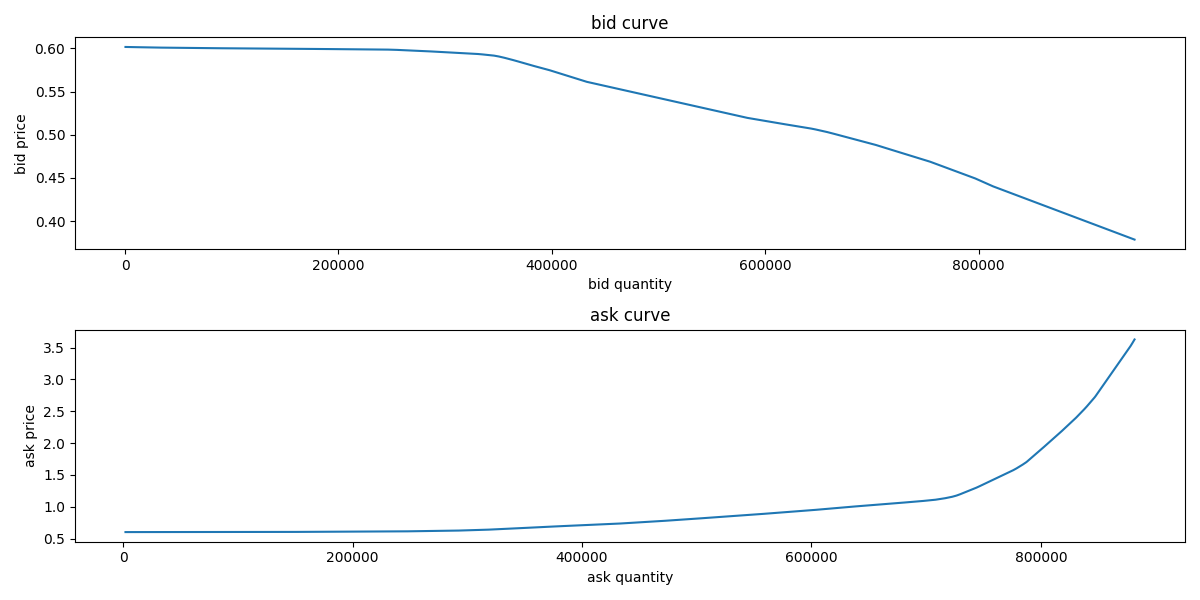

In [47]:
%matplotlib ipympl
bid_price = [item[0] for item in bid_list]
bid_quantity = [item[1] for item in bid_list]
ask_price = [item[0] for item in ask_list]
ask_quantity =  [item[1] for item in ask_list]

fp.interactive_fair_price(bid_quantity,bid_price,ask_quantity,ask_price)